In [1]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

# 1. DATA CLEANING

In [2]:
###' ################################################################################
###'
###' Data Load 
###'
###'

### daata load
df= pd.read_csv("data/2_345(1970-1979).csv")
df_S = df[['Authors','Title','Year','Volume']]
df_clean = df_S.dropna(subset = ['Title'])

#spell = SpellChecker()
#df_clean['Title_spell'] = df_clean['Title'].map(lambda x: spell.correction(x))
#df_clean['Abstract_spell'] = df_clean['Abstract'].map(lambda x: spell.correction(x))

df_clean.head(5)

,Authors,Title,Year,Volume
0,ERLICH O.; BORICH G.,OCCURRENCE AND GENERALIZABILITY OF SCORES ON A...,1979,16
1,SHANI E.; PETROSKO J.M.,STRUCTURAL COMPONENTS DERIVED FROM EVALUATING ...,1976,13
2,ROWLEY G.L.; TRAUB R.E.,"FORMULA SCORING, NUMBER‐RIGHT SCORING, AND TES...",1977,14
3,ALGINA J.; NOE M.J.,A STUDY OF THE ACCURACY OF SUBKOVIAK'S SINGLE‐...,1978,15
4,SCHWARTZ S.A.,A COMPREHENSIVE SYSTEM FOR ITEM ANALYSIS IN PS...,1978,15


In [3]:
###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    
    # when text is None
    if text is None:  
        return None
    
    # add more stop words
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"use","education","measurement","model","Education","Measurement","Model"}
    
    punc = set(punctuation)
    
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith(".")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith(".")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

In [4]:
###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

# tokenize
#df_clean['A_tokens'] = df_clean['Abstract_spell'].map(lambda x: rem_punc_stop(x))
df_clean['T_tokens_'] = df_clean['Title'].map(lambda x: rem_punc_stop(x))
df_clean['T_tokens'] = df_clean['T_tokens_'].map(lambda tokens: [token.lower() for token in tokens])

#df_clean['A_tokens']
df_clean['T_tokens']

0      [occurrence, generalizability, scores, classro...
1      [structural, component, derived, evaluate, sta...
2      [formula, scoring, number‐right, scoring, test...
3      [study, accuracy, subkoviaks, single‐administr...
4      [comprehensive, system, item, analysis, psycho...
                             ...                        
340         [student, course, evaluation, questionnaire]
341    [predict, graduation, withdrawal, failure, col...
342                            [rejoinder, knapps, note]
343    [test, item, arrangement, testing, time, perfo...
344    [convergent, discriminant, validity, measures,...
Name: T_tokens, Length: 345, dtype: object

# 2. WORD CLOUDS

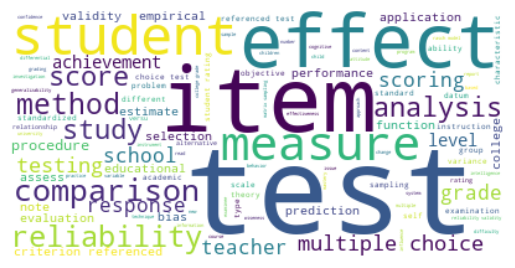

In [5]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###'
###'

### 2. Title

# apply function to text object
TO_text = ' '.join(df_clean['T_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
TO_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(TO_text)          

# plot 
plt.imshow(TO_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                              

# 3. WORDS FREQUENCY

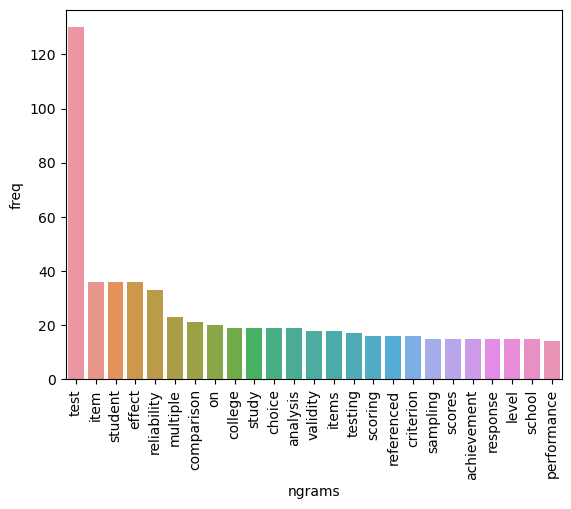

In [6]:
###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ unigrams
###'
###'

### join token
df_clean['T_tokens_join'] = df_clean['T_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


### most frequent unigrams  _____ Title one word
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(df_clean['T_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

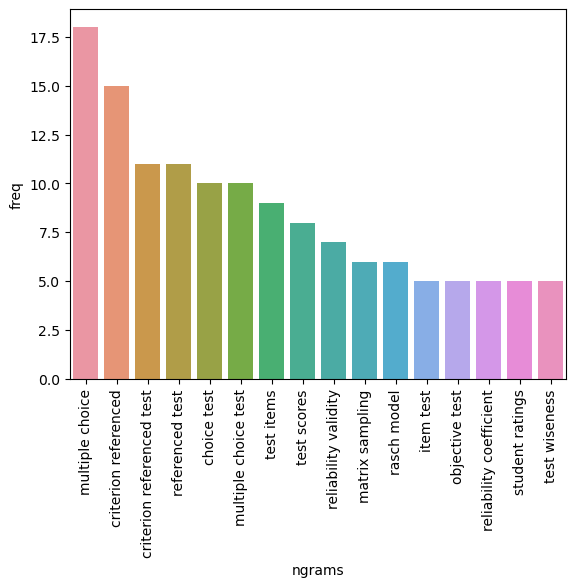

In [7]:
### most frequent bigrams _____ Abstract two words
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))
ngrams = countvec.fit_transform(df_clean['T_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

In [8]:
csv_file_path = 'data/2_output.csv'
df_clean.to_csv(csv_file_path, index=False)